## 1. Предобработка
Выполняем все те же операции, что и в бейслайне

In [30]:
# Необходимо для корректной работы внешних .py файлов
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, TargetEncoder
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from lightgbm import LGBMClassifier
from helper import *
from plots import *
import random

In [32]:
# фиксируем состояние генератора псевдослучайных чисел. Это необходимо, чтобы результаты модели не менялись с каждым новым запуском 
SEED = 42 # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

In [44]:
df = pd.read_csv("data.csv", sep=";")

In [45]:
df.head(4)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no


## 1. Предобработка

In [46]:
# Общие преобразования
df_preprocessed = df.copy()

num_cols = ['balance', 'age', 'day','duration','campaign','pdays','previous']
for c in num_cols:
    df_preprocessed[c] = pd.to_numeric(df_preprocessed[c], errors='coerce')

for c in ['job','marital','education','default','housing','loan','contact','poutcome','month','y']:
    df_preprocessed[c] = df_preprocessed[c].astype('category')

# Упорядочим month
months_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
df_preprocessed['month'] = pd.Categorical(df_preprocessed['month'],
                                          categories=months_order, ordered=True)
# флаг для специального значения pdays == -1
df_preprocessed['pdays_never'] = (df_preprocessed['pdays'] == -1).astype('int8')

# Кодирование таргета
df_preprocessed['y'] = np.where(df_preprocessed['y'] == 'yes', 1, 0)

df_preprocessed.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,pdays_never
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,1


In [47]:
# делим данные на признаки и таргет
X, y = divide_data(df_preprocessed, 'y')

In [48]:
# кодируем месяц числом и строим порядок дат month*100 + day
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,
             'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}

mnum = X['month'].astype(str).str.lower().map(month_map)
dayv = X['day'].astype('Int64')

date_ord = (mnum * 100 + dayv).astype('Int64')

# сортируем train по времени (TimeSeriesSplit режет по индексу)
idx_sorted = np.argsort(date_ord.fillna(-1).to_numpy())
X_sorted = X.iloc[idx_sorted].reset_index(drop=True)
y_sorted = y.iloc[idx_sorted].reset_index(drop=True)

# 2) временной холд-аут (последние 20% — тест)
cut = int(len(X_sorted)*0.8)
X_train, y_train = X_sorted.iloc[:cut], X_sorted.iloc[cut:]
y_train, y_test = y_sorted.iloc[:cut], y_sorted.iloc[cut:]

In [49]:
categorical_cols = ['job','marital','education','default','housing','loan',
                    'contact','month','poutcome']
numeric_cols_base = ['age','balance','day','campaign','pdays','previous','pdays_never']

# Будем использовать порядковое кодирование. Для этого выпишем все категории для каждого столбца в порядке увеличения номера
cat_orders = {
    'default':  ['no', 'yes'],
    'housing':  ['no', 'yes'],
    'loan':     ['no', 'yes'],
    'contact':  ['unknown', 'telephone', 'cellular'],
    'month':    ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
    'poutcome': ['failure', 'other', 'success', 'unknown'],  # «unknown» отдельно
}

# — для остальных берём стабильный алфавитный порядок из train
for col in ['job', 'marital', 'education']:
    cat_orders[col] = sorted(df_preprocessed[col].dropna().astype(str).unique().tolist())

encoder = OrdinalEncoder(
    categories=[cat_orders[c] for c in categorical_cols],
    handle_unknown='use_encoded_value',
    unknown_value=-1,
    dtype='int16'
)

numeric_cols_no_dur  = ['age','balance','day','campaign','pdays','previous','pdays_never']
numeric_cols_with_dur = numeric_cols_no_dur + ['duration']   # для референса

# пайплайн
preprocessor = Pipeline([
    ('nan_remover', ColumnTransformer(
        transformers=[
            ('most_frequent_numeric', SimpleImputer(strategy='most_frequent'), numeric_cols_no_dur),
            ('most_frequent_cat',    SimpleImputer(strategy='most_frequent'), categorical_cols),
            ('mean',                 SimpleImputer(strategy='mean'),          [])  # если вдруг захочешь добавить
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
    ('transformations', ColumnTransformer(
        transformers=[
            ('encoder', encoder, categorical_cols)   # <- используем твой уже созданный encoder
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
])
preprocessor.set_output(transform='pandas')

,steps,"[('nan_remover', ...), ('transformations', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('most_frequent_numeric', ...), ('most_frequent_cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [50]:
# сохраним все бейслайн модели в виде списка для удобства
models = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED)),
    ('LGBMClassifier', LGBMClassifier(random_state=SEED))
]

In [51]:
# используем 5-блочную кросс-валидацию, учитывающую распределение таргета при разбиении
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

Удаляем duration, тк это утечка, длительность звонка известна только после контакта и фактически отражает интерес клиента; duration почти напрямую коррелирует с y (дольше говорят — чаще оформляют), из-за чего метрики взлетают нечестно.

In [52]:
cols_to_drop = ['duration']
X_train = X_train.drop(columns=cols_to_drop).copy()

In [53]:
cv = TimeSeriesSplit(n_splits=5)  # expanding window, shuffle=False по умолчанию

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 16
[LightGBM] [Info] [binar

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

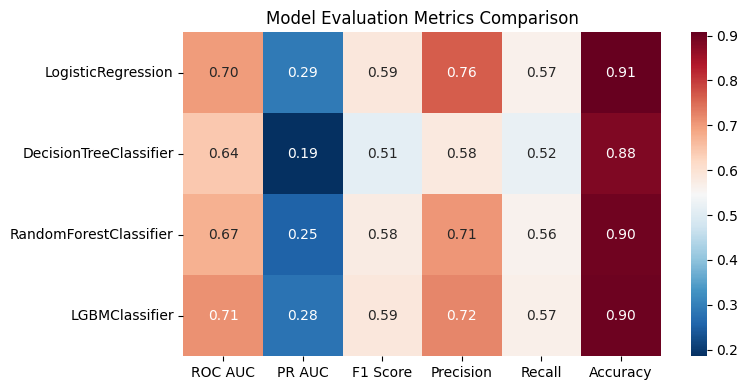

In [54]:
initial_metrics = train_evaluate_models_cv(
    models=models,
    X=X_train,
    y=y_train,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

## 2. Преобразования данных и feature engineering

### 2.1 Логарифмическое преобразование
В нашем датасете имеются "денежные" признаки balance, campaign, previous, которые имеют асимметричное распределение. Логарифмирование позволит сделать их более нормальными

#### 2.1.1 Без удаления столбцов

In [55]:
X_log = X_train.copy()

In [56]:
def signed_log1p(s):
    """лог с сохранением знака (для balance, где есть отрицательные)"""
    return np.sign(s) * np.log1p(np.abs(s))

In [57]:
X_log['balanceLog']  = signed_log1p(X_log['balance'])
X_log['campaignLog'] = np.log1p(X_log['campaign'])
X_log['previousLog'] = np.log1p(X_log['previous'])

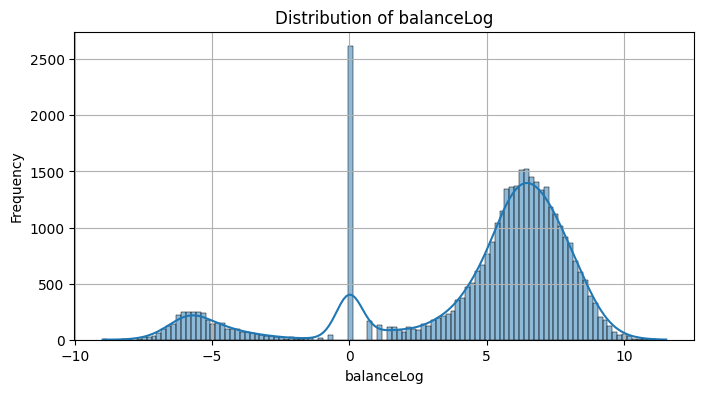

In [58]:
plot_hist_numeric(X_log, 'balanceLog')

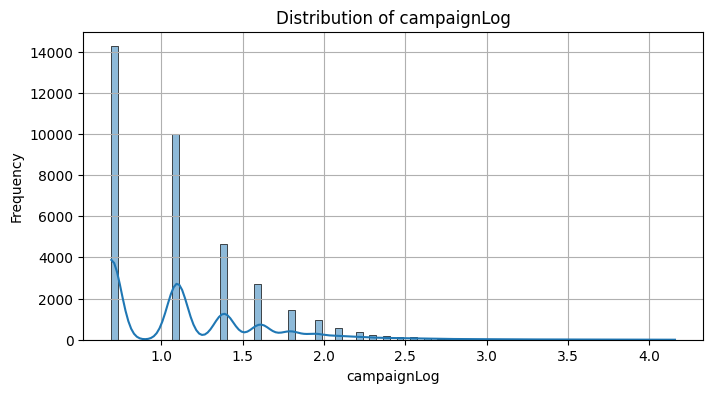

In [59]:
plot_hist_numeric(X_log, 'campaignLog')

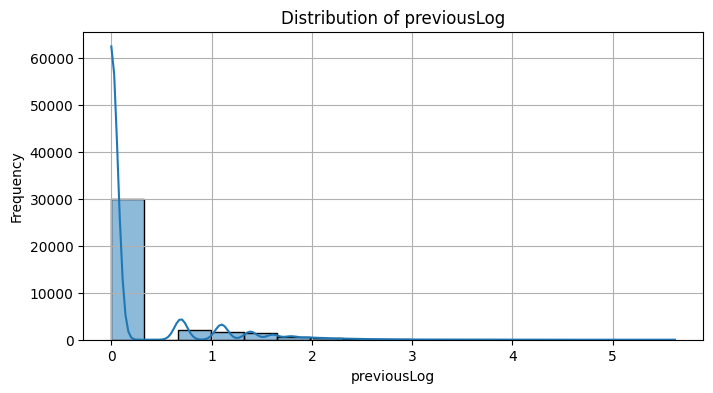

In [60]:
plot_hist_numeric(X_log, 'previousLog')

логарифмирование помогло, но распределения всё ещё не нормальные; главные причины — нули/дискретность (campaign, previous) и смесь знаков (balance).

In [61]:
#добавим новую колонку в препроцессор, чтобы пропуски в ней также заполнились
preprocessor_log = clone(preprocessor)
preprocessor_log['nan_remover'].transformers[2][2].append('balanceLog')

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 19
[LightGBM] [Info] [binar

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

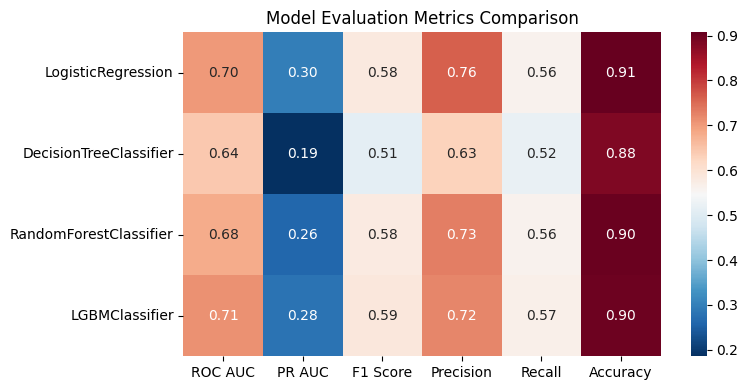

In [62]:
log_metrics = train_evaluate_models_cv(
    models=models,
    X=X_log,
    y=y_train,
    preprocessor=preprocessor_log,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.004107  0.005425 -0.005069  -0.000662 -0.003751   
 DecisionTreeClassifier  0.000414  0.000579  0.000393   0.050017  0.000207   
 RandomForestClassifier  0.005543  0.006069  0.004141   0.025595  0.000297   
 LGBMClassifier          0.000000  0.000000  0.000000   0.000000  0.000000   
 
                         Accuracy  
 LogisticRegression     -0.000066  
 DecisionTreeClassifier  0.000066  
 RandomForestClassifier  0.006403  
 LGBMClassifier          0.000000  )

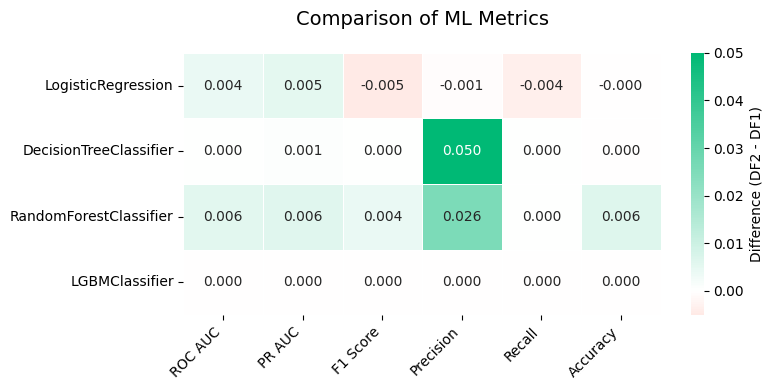

In [63]:
# сравним изначальные метрики с метриками после логарифмирования и выведем график
compare_metrics_heatmap(initial_metrics, log_metrics)

улучшений особо нет

#### 2.1.2 С удалением исходных столбцов

In [64]:
X_log_delete = X_train.copy()

In [65]:
X_log_delete['balanceLog']  = signed_log1p(X_log_delete['balance'])
X_log_delete['campaignLog'] = np.log1p(X_log_delete['campaign'])
X_log_delete['previousLog'] = np.log1p(X_log_delete['previous'])

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 19
[LightGBM] [Info] [binar

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

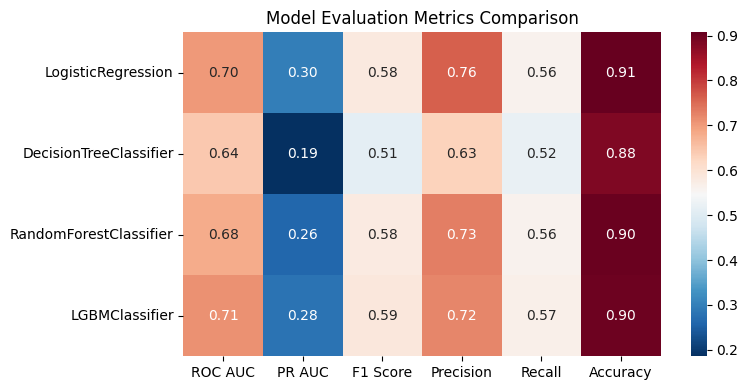

In [66]:
log_delete_metrics = train_evaluate_models_cv(
    models=models,
    X=X_log_delete,
    y=y_train,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.004107  0.005425 -0.005069  -0.000662 -0.003751   
 DecisionTreeClassifier  0.000414  0.000579  0.000393   0.050017  0.000207   
 RandomForestClassifier  0.005543  0.006069  0.004141   0.025595  0.000297   
 LGBMClassifier          0.000000  0.000000  0.000000   0.000000  0.000000   
 
                         Accuracy  
 LogisticRegression     -0.000066  
 DecisionTreeClassifier  0.000066  
 RandomForestClassifier  0.006403  
 LGBMClassifier          0.000000  )

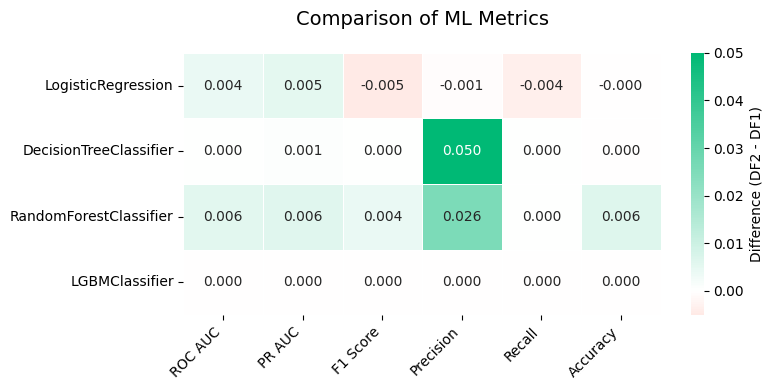

In [67]:
compare_metrics_heatmap(initial_metrics, log_delete_metrics)

C удалением столбцов преобразование работает хуже

### 2.2 Создание нового признака "TotalContacts"
Общее число контактов за всю историю: текущая кампания + прошлые контакты

In [68]:
X_total = X_train.copy()

In [69]:
X_total["TotalContacts"] = (
    X_total["campaign"].fillna(0) + X_total["previous"].fillna(0)
)
#X_total = X_total.drop(columns=["campaign", "previous"])

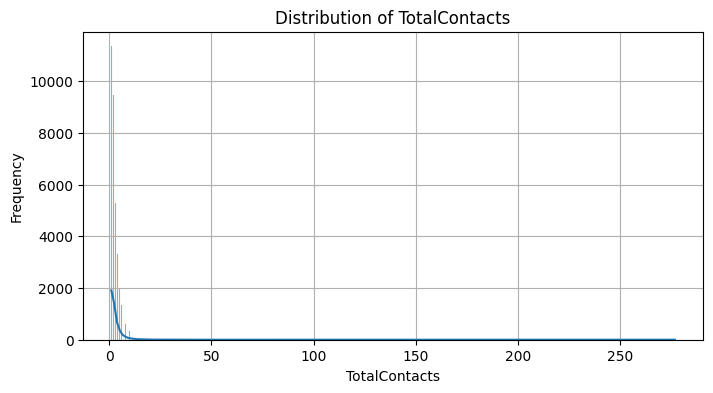

In [70]:
plot_hist_numeric(X_total, 'TotalContacts')

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 724
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 17
[LightGBM] [Info] [binar

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

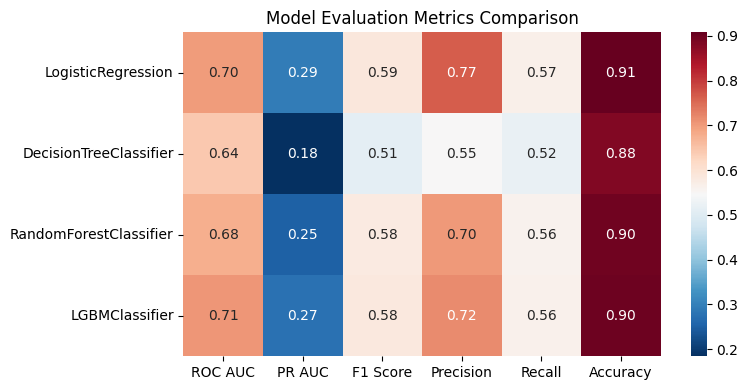

In [71]:
total_income_metrics = train_evaluate_models_cv(
    models=models,
    X=X_total,
    y=y_train,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.001518  0.001515  0.001422   0.002177  0.000973   
 DecisionTreeClassifier -0.000207 -0.001059 -0.000810  -0.032188 -0.000979   
 RandomForestClassifier  0.003829 -0.001633  0.001509  -0.004849  0.000194   
 LGBMClassifier         -0.005456 -0.005983 -0.002707  -0.004864 -0.002328   
 
                         Accuracy  
 LogisticRegression      0.000431  
 DecisionTreeClassifier -0.001758  
 RandomForestClassifier  0.001327  
 LGBMClassifier         -0.001261  )

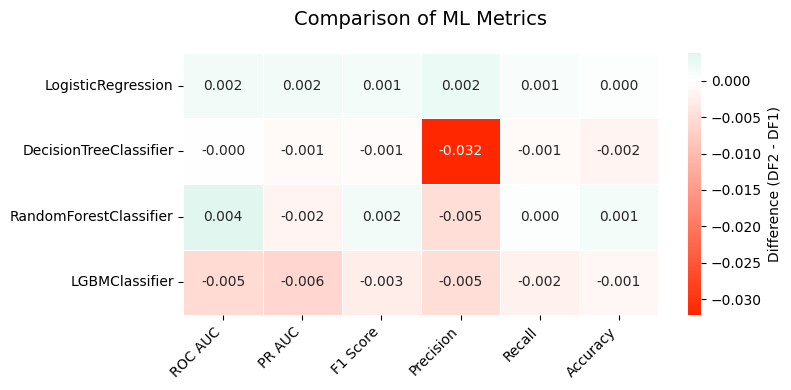

In [72]:
compare_metrics_heatmap(initial_metrics, total_income_metrics)

Наблюдаем ухудшение всех метрик

### 2.3 HasAnyCredit есть ли у клиента какие-то кредиты (ипотека или потребкредит)

In [73]:
X_has = X_train.copy()

In [74]:
X_has["HasAnyCredit"] = np.where(
    (X_has["housing"].fillna("no") == "yes") | (X_has["loan"].fillna("no") == "yes"),
    1, 0
).astype("int8")

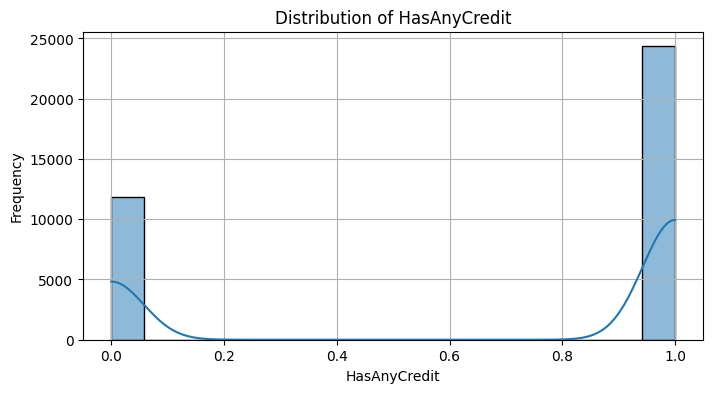

In [75]:
plot_hist_numeric(X_has, 'HasAnyCredit')

In [76]:
preprocessor_lir = clone(preprocessor)
preprocessor_lir['nan_remover'].transformers[2][2].append('HasAnyCredit')

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 17
[LightGBM] [Info] [binar

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

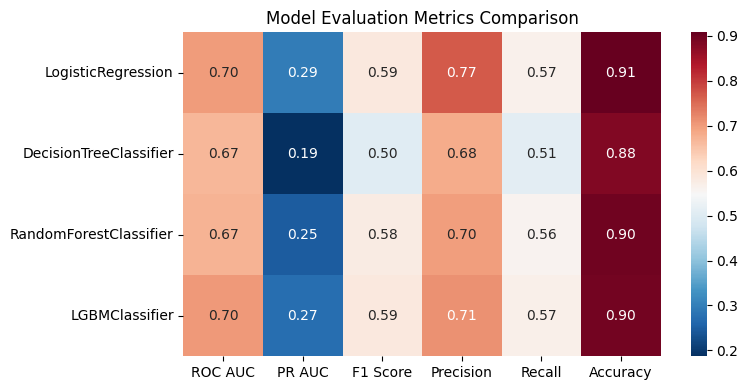

In [77]:
lir_metrics = train_evaluate_models_cv(
    models=models,
    X=X_has,
    y=y_train,
    preprocessor=preprocessor_lir,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.003077  0.001848  0.000707   0.003533  0.000340   
 DecisionTreeClassifier  0.022054  0.001919 -0.007077   0.101178 -0.009475   
 RandomForestClassifier -0.000815 -0.004400  0.000055  -0.009245 -0.000871   
 LGBMClassifier         -0.007996 -0.007252 -0.000940  -0.009549  0.001158   
 
                         Accuracy  
 LogisticRegression      0.000498  
 DecisionTreeClassifier -0.001692  
 RandomForestClassifier -0.000398  
 LGBMClassifier         -0.005010  )

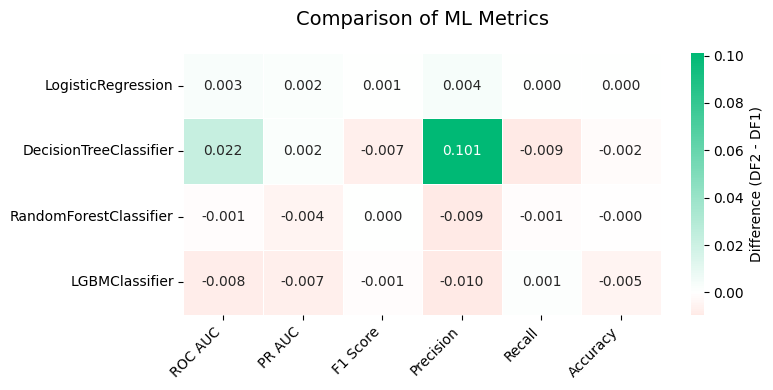

In [78]:
compare_metrics_heatmap(initial_metrics, lir_metrics)

Видны небольшие колебания

сочетать «частоту и давность» контактов (total_contacts, contact_intensity, pdays_recency), добавить простые финансовые взаимодействия (balance_per_age, any_loan/loan_count) и учесть сезонность (month_sin/cos).

c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1470
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1494
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 25
[LightGBM] [Info] [bin

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

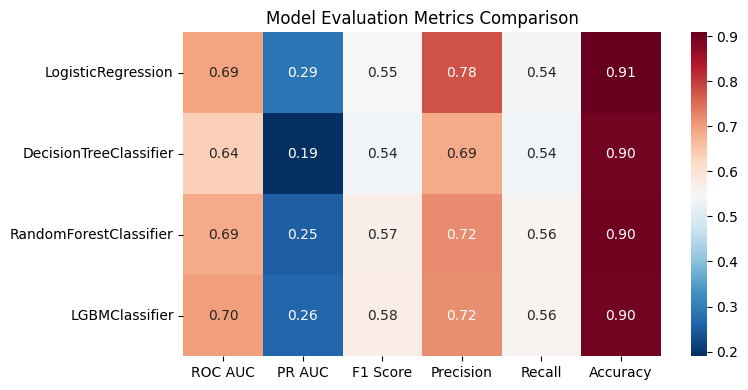

,ROC AUC,PR AUC,F1 Score,Precision,Recall,Accuracy
LogisticRegression,0.694641,0.287764,0.551515,0.778392,0.541490,0.908427
DecisionTreeClassifier,0.635245,0.189644,0.536418,0.686235,0.536308,0.895090
RandomForestClassifier,0.686118,0.253007,0.572268,0.719739,0.557134,0.898938
LGBMClassifier,0.697865,0.263367,0.575323,0.717037,0.558689,0.896417


In [79]:
# 1) Cоздаём продвинутые признаки
X_fe = X_train.copy()

# --- контакты и "давление" кампании ---
X_fe["total_contacts"]   = X_fe["campaign"].fillna(0) + X_fe["previous"].fillna(0)
X_fe["was_contacted"]    = (X_fe["previous"].fillna(0) > 0).astype("int8")

# recency: чем ближе последний контакт (малый pdays), тем больше score
p = X_fe["pdays"].fillna(-1)
X_fe["pdays_recency"]    = np.where(p == -1, 0.0, 1.0 / np.log1p(p))  # 0 для «никогда», иначе ~1/log(1+p)

# интенсивность текущих контактов с учётом «давности» предыдущих
X_fe["contact_intensity"] = X_fe["campaign"] / (np.where(p == -1, 30, p + 1))  # недавний контакт => выше

# --- финансовые/соц признаки ---
X_fe["any_loan"]        = ((X_fe["housing"] == "yes") | (X_fe["loan"] == "yes")).astype("int8")
X_fe["loan_count"]      = (X_fe["housing"] == "yes").astype("int8") + (X_fe["loan"] == "yes").astype("int8")
X_fe["balance_per_age"] = X_fe["balance"] / (X_fe["age"] + 1)

# --- сезонность месяца (циклическое кодирование) ---
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
mnum = X_fe["month"].map(month_map).astype(float)
X_fe["month_sin"] = np.sin(2*np.pi*mnum/12.0)
X_fe["month_cos"] = np.cos(2*np.pi*mnum/12.0)

# 2) Подключим новые числовые фичи к имьютеру числовых колонок в твоём препроцессоре
from sklearn.base import clone
preprocessor_fe = clone(preprocessor)  # или preprocessor_no_dur — тот, который ты сейчас используешь

new_num_cols = [
    "total_contacts","was_contacted","pdays_recency","contact_intensity",
    "any_loan","loan_count","balance_per_age","month_sin","month_cos"
]

# добавляем их в список числовых колонок для имьютации (у тебя это первый трансформер)
preprocessor_fe.named_steps["nan_remover"].transformers[0][2].extend(new_num_cols)

# 3) Прогоняем CV
fe_metrics = train_evaluate_models_cv(
    models=models,
    X=X_fe, y=y_train,
    preprocessor=preprocessor_fe,
    cv=cv,          
    seed=SEED
)
fe_metrics

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.003077  0.001848  0.000707   0.003533  0.000340   
 DecisionTreeClassifier  0.022054  0.001919 -0.007077   0.101178 -0.009475   
 RandomForestClassifier -0.000815 -0.004400  0.000055  -0.009245 -0.000871   
 LGBMClassifier         -0.007996 -0.007252 -0.000940  -0.009549  0.001158   
 
                         Accuracy  
 LogisticRegression      0.000498  
 DecisionTreeClassifier -0.001692  
 RandomForestClassifier -0.000398  
 LGBMClassifier         -0.005010  )

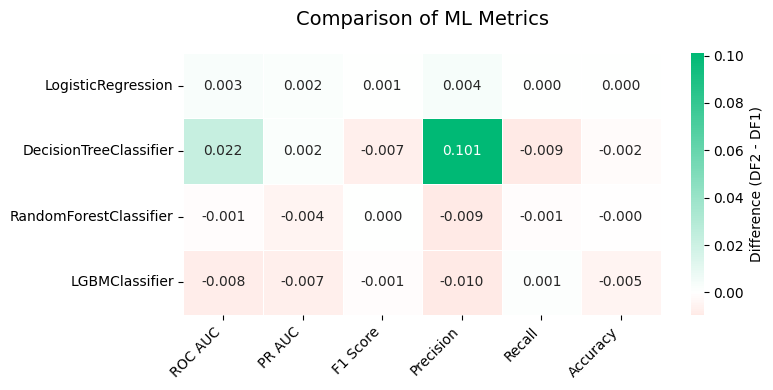

In [80]:
compare_metrics_heatmap(initial_metrics, lir_metrics)

В основном небольшие ухудшения

# FirstCall - первый звонок в кампании

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139599 -> initscore=-1.818628
[LightGB

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

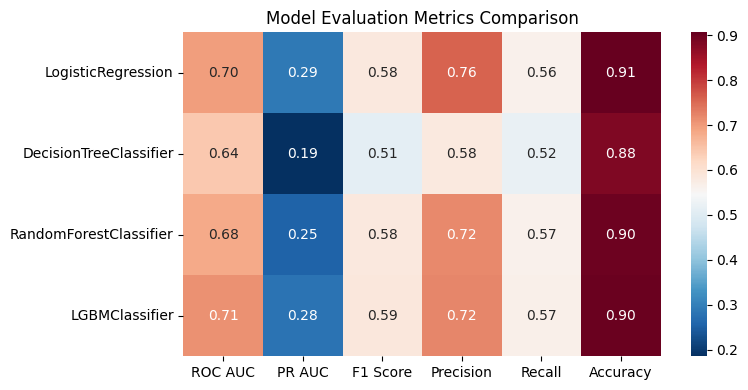

In [ ]:
# 1 фича: первый звонок в кампании
X_1f = X_train.copy()
X_1f["FirstCall"] = (X_1f["campaign"].fillna(0) == 1).astype("int8")

preprocessor_1f = clone(preprocessor)  

ct = preprocessor_1f.named_steps["nan_remover"]
trs = list(ct.transformers)
for i, (name, trf, cols) in enumerate(trs):
    if name == "mean":
        cols = list(cols) + ["FirstCall"]
        trs[i] = (name, trf, cols)
        break
preprocessor_1f.set_params(nan_remover__transformers=trs)

metrics_1f = train_evaluate_models_cv(
    models=models,
    X=X_1f,
    y=y_train,
    preprocessor=preprocessor_1f,
    cv=cv,       
    seed=SEED
)


(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression     -0.002719 -0.004117 -0.002883  -0.004252 -0.002088   
 DecisionTreeClassifier  0.000036  0.000202  0.000009   0.000001  0.000018   
 RandomForestClassifier  0.007531  0.000621  0.006897   0.012608  0.004259   
 LGBMClassifier         -0.000500 -0.000775 -0.000414   0.000491 -0.000361   
 
                         Accuracy  
 LogisticRegression     -0.000863  
 DecisionTreeClassifier  0.000033  
 RandomForestClassifier  0.001493  
 LGBMClassifier         -0.000133  )

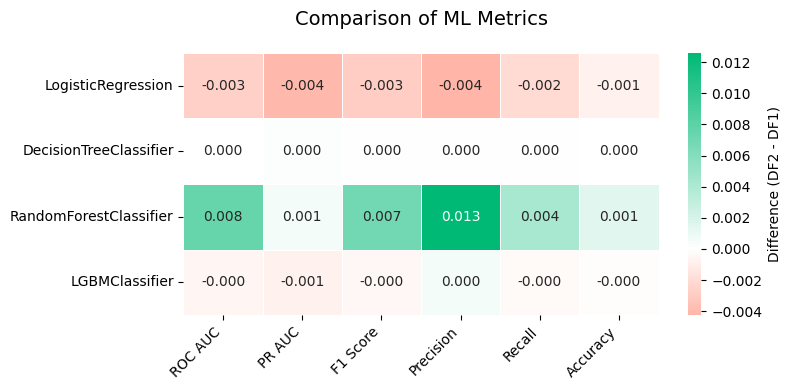

In [82]:
compare_metrics_heatmap(initial_metrics, metrics_1f)

Немного улучшился лес, ухудшилась регрессия

### 2.4 Биннинг для campaign
Как мы убедились ранее, этот признак по сути категориальный, поэтому имеет смысл сделать биннинг и порядковое кодирование

#### 2.4.1 Без удаления

In [83]:
x_campaign_binning = X_train.copy()

In [84]:
bins   = [-np.inf, 1, 3, 5, np.inf]
labels = [0, 1, 2, 3]

x_campaign_binning['campaign_bins'] = pd.cut(
    x_campaign_binning['campaign'], bins=bins, labels=labels
).astype('int16')

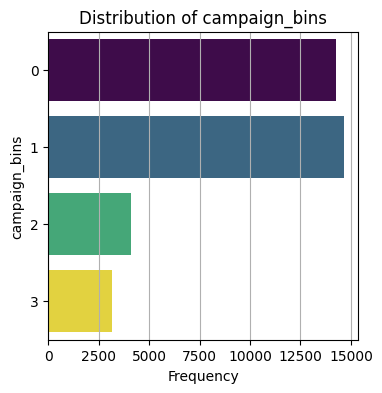

In [85]:
plot_hist_categorical(x_campaign_binning, 'campaign_bins')

In [86]:
preprocessor_campaign_binning = clone(preprocessor)
preprocessor_campaign_binning['nan_remover'].transformers[0][2].append('campaign_bins')

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139599 -> initscore=-1.818628
[LightGB

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

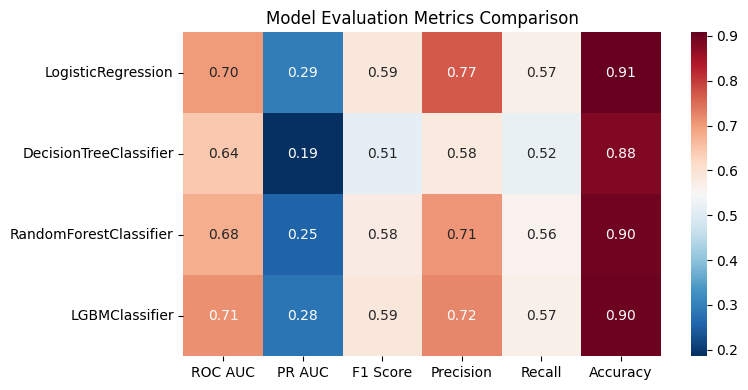

In [87]:
campaign_binning_metrics = train_evaluate_models_cv(
    models=models,
    X=x_campaign_binning,
    y=y_train,
    preprocessor=preprocessor_campaign_binning,
    cv=cv,   
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.001798  0.001714  0.003145   0.004808  0.002153   
 DecisionTreeClassifier  0.000036  0.000202  0.000009   0.000001  0.000018   
 RandomForestClassifier  0.003185 -0.000066  0.001676  -0.001165  0.001030   
 LGBMClassifier          0.000846  0.000395  0.000603   0.001585  0.000452   
 
                         Accuracy  
 LogisticRegression      0.000796  
 DecisionTreeClassifier  0.000033  
 RandomForestClassifier -0.000431  
 LGBMClassifier          0.000299  )

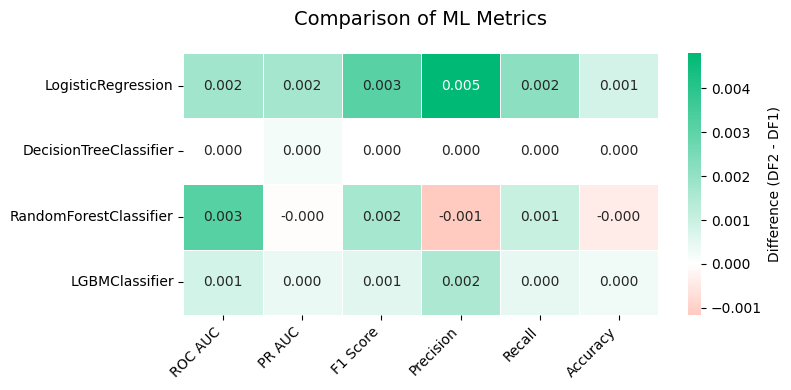

In [88]:
compare_metrics_heatmap(initial_metrics, campaign_binning_metrics)

Небольшие улучшения

### 2.5 Применение StandardScaler (стандартизация)

#### 2.5.1 Без удаления

In [93]:
X_standard_scaler = X_train.copy()

In [94]:
scaled_columns = ['balanceScaled', 'campaignScaled', 'previousScaled']
X_standard_scaler[scaled_columns] = X_standard_scaler[['balance', 'campaign', 'previous']]

In [95]:
preprocessor_standard_scaler = clone(preprocessor)

preprocessor_standard_scaler['transformations'].transformers.append(
    ('scaler', StandardScaler(), scaled_columns)
)

preprocessor_standard_scaler['nan_remover'].transformers[0][2].extend(scaled_columns)

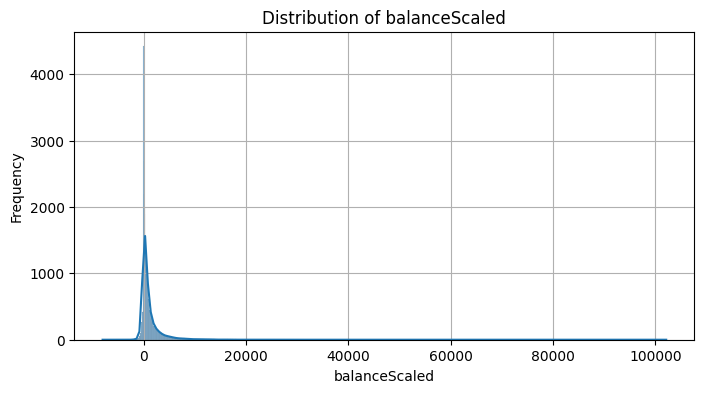

In [96]:
plot_hist_numeric(X_standard_scaler, 'balanceScaled')

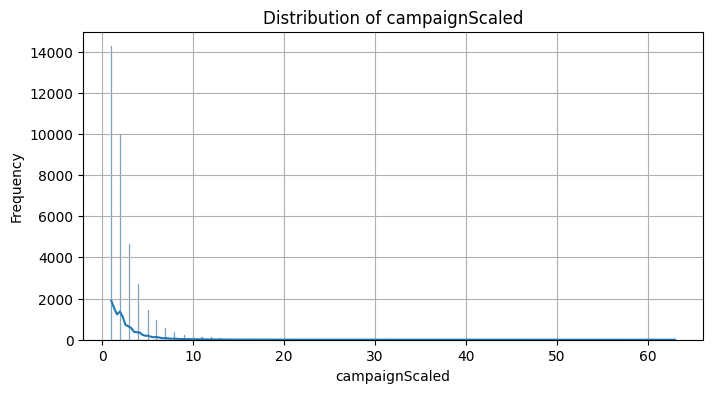

In [97]:
plot_hist_numeric(X_standard_scaler, 'campaignScaled')

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 983
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 995
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 19
[LightGBM] [Info] [binar

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

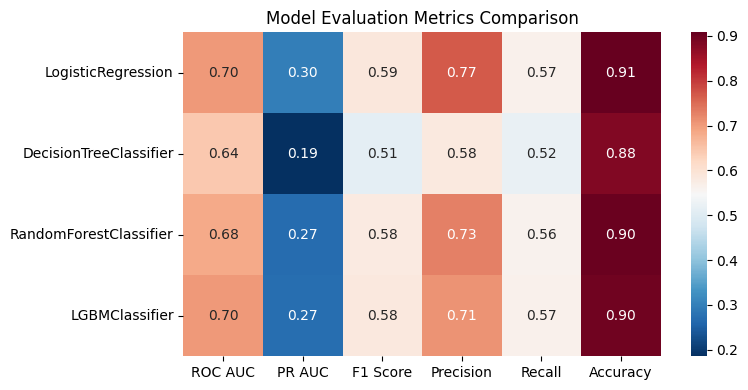

In [98]:
standard_scaler_metrics = train_evaluate_models_cv(
    models=models,
    X=X_standard_scaler,
    y=y_train,
    preprocessor=preprocessor_standard_scaler,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.004617  0.003199  0.001785   0.005293  0.001113   
 DecisionTreeClassifier  0.000036  0.000202  0.000009   0.000001  0.000018   
 RandomForestClassifier  0.010217  0.014727  0.004866   0.022297  0.002350   
 LGBMClassifier         -0.006832 -0.008378 -0.002670  -0.014342 -0.001468   
 
                         Accuracy  
 LogisticRegression      0.000829  
 DecisionTreeClassifier  0.000033  
 RandomForestClassifier  0.005309  
 LGBMClassifier         -0.002057  )

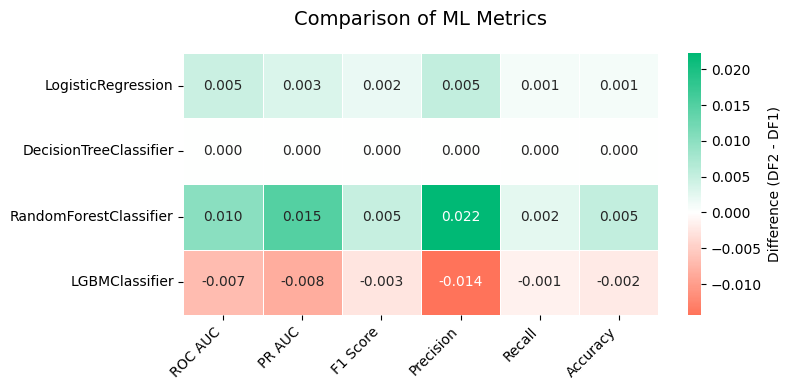

In [99]:
compare_metrics_heatmap(initial_metrics, standard_scaler_metrics)

Улучшился только случайный лес, ухудшился бустинг

#### 2.5.2 С удалением

In [100]:
X_standard_scaler_del = X_train.copy()

In [101]:
preprocessor_standard_scaler_del = clone(preprocessor)

preprocessor_standard_scaler_del['transformations'].transformers.append(
    ('scaler', StandardScaler(), ['balance', 'campaign', 'previous'])
)

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 16
[LightGBM] [Info] [binar

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

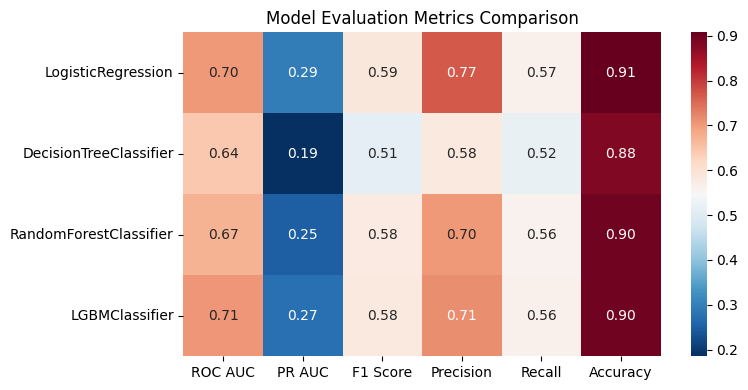

In [102]:
standard_scaler_metrics_del = train_evaluate_models_cv(
    models=models,
    X=X_standard_scaler_del,
    y=y_train,
    preprocessor=preprocessor_standard_scaler_del,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.003018  0.002059  0.001403   0.003242  0.001032   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier -0.002679 -0.003549  0.002725  -0.001974  0.001697   
 LGBMClassifier         -0.004208 -0.005989 -0.005345  -0.008817 -0.002779   
 
                         Accuracy  
 LogisticRegression      0.000564  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier  0.000365  
 LGBMClassifier         -0.003782  )

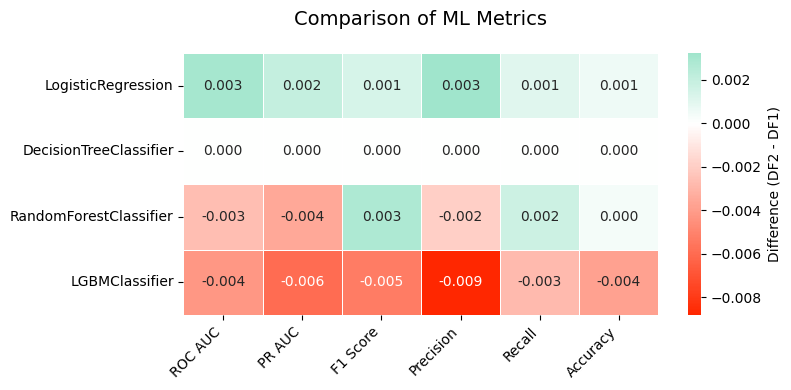

In [103]:
compare_metrics_heatmap(initial_metrics, standard_scaler_metrics_del)

Ухудшения в бустинге

### 2.6 Нормализация

#### 2.6.1 Без удаления

In [104]:
X_normalised = X_train.copy()

In [105]:
scaled_columns = ['balanceScaled', 'campaignScaled', 'previousScaled']
X_normalised[scaled_columns] = X_normalised[['balance', 'campaign', 'previous']]

In [106]:
preprocessor_normalisation = clone(preprocessor)

preprocessor_normalisation['transformations'].transformers.append(
    ('scaler', MinMaxScaler(), scaled_columns)
)

preprocessor_normalisation['nan_remover'].transformers[0][2].extend(scaled_columns)

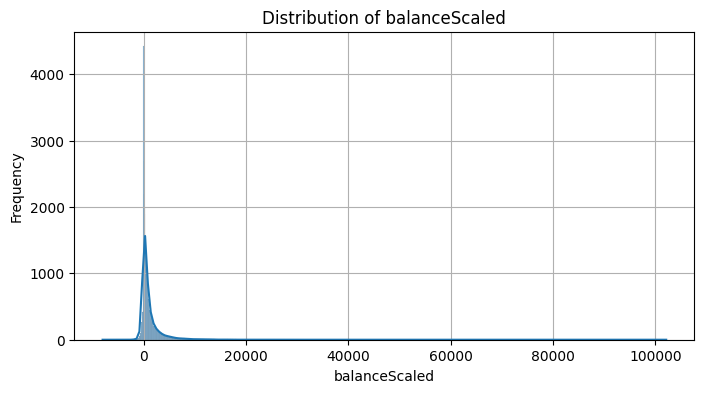

In [107]:
plot_hist_numeric(X_normalised, 'balanceScaled')

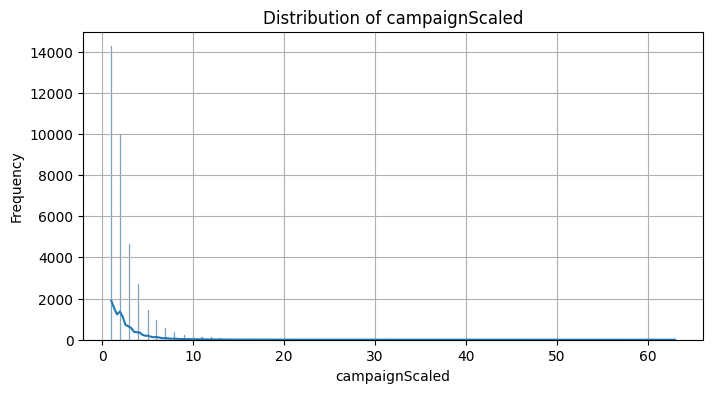

In [108]:
plot_hist_numeric(X_normalised, 'campaignScaled')

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 993
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139599 -> initscore=-1.818628
[LightGB

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

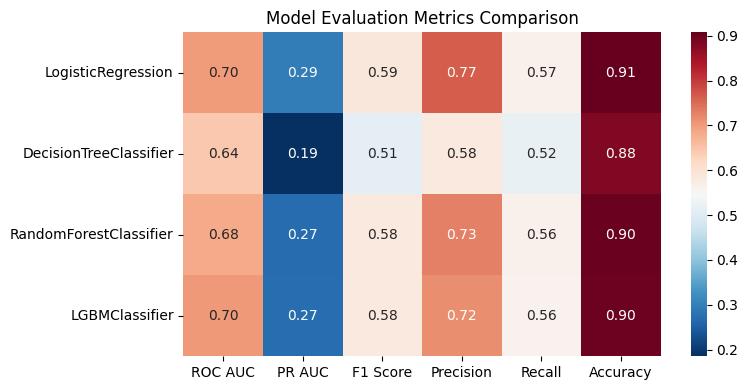

In [109]:
normalised_metrics = train_evaluate_models_cv(
    models=models,
    X=X_normalised,
    y=y_train,
    preprocessor=preprocessor_normalisation,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.002531  0.001898  0.001467   0.002279  0.000969   
 DecisionTreeClassifier  0.000036  0.000202  0.000009   0.000001  0.000018   
 RandomForestClassifier  0.010154  0.014685  0.005094   0.022448  0.002520   
 LGBMClassifier         -0.007502 -0.009238 -0.004867  -0.007059 -0.004453   
 
                         Accuracy  
 LogisticRegression      0.000464  
 DecisionTreeClassifier  0.000033  
 RandomForestClassifier  0.005375  
 LGBMClassifier         -0.001924  )

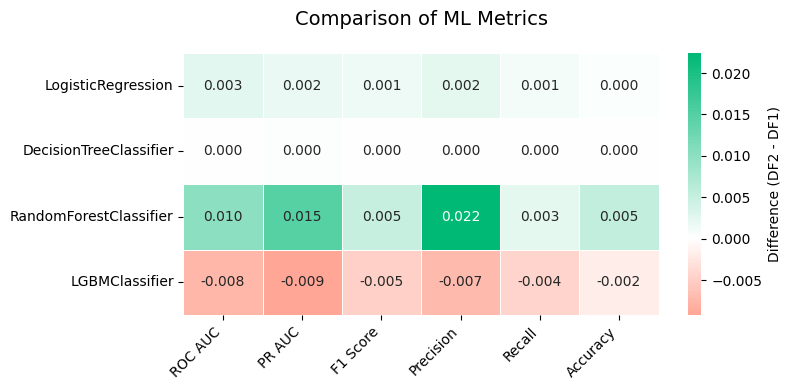

In [110]:
compare_metrics_heatmap(initial_metrics, normalised_metrics)

В основном только ухудшение метрик

#### 2.6.2 С удалением

In [111]:
X_normalised_del = X_train.copy()

In [112]:
preprocessor_normalisation_del = clone(preprocessor)

preprocessor_normalisation_del['transformations'].transformers.append(
    ('scaler', MinMaxScaler(), ['balance', 'campaign', 'previous'])
)

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 16
[LightGBM] [Info] [binar

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

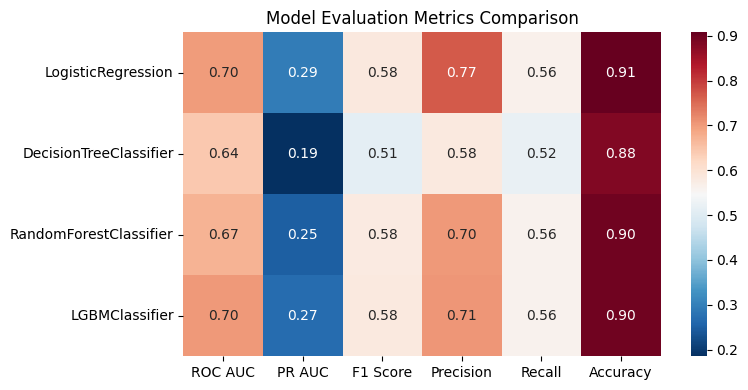

In [113]:
normalised_metrics_del = train_evaluate_models_cv(
    models=models,
    X=X_normalised_del,
    y=y_train,
    preprocessor=preprocessor_normalisation_del,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.001881  0.002111 -0.001035   0.004332 -0.000825   
 DecisionTreeClassifier  0.000000  0.000000  0.000000   0.000000  0.000000   
 RandomForestClassifier -0.002908 -0.003867  0.002421  -0.002044  0.001376   
 LGBMClassifier         -0.008667 -0.011914 -0.005587  -0.015507 -0.004567   
 
                         Accuracy  
 LogisticRegression      0.000365  
 DecisionTreeClassifier  0.000000  
 RandomForestClassifier  0.000299  
 LGBMClassifier         -0.003251  )

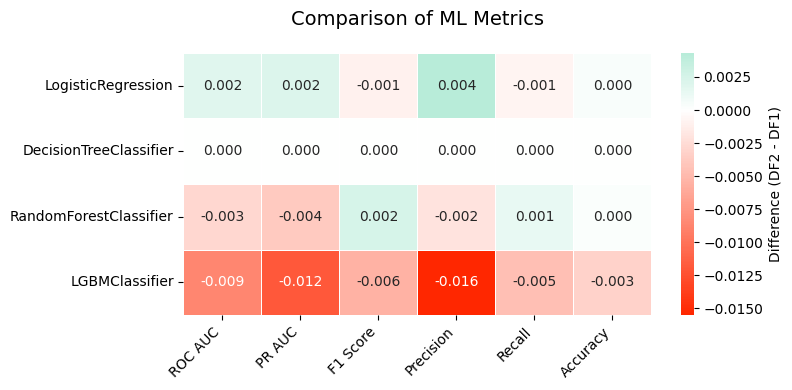

In [114]:
compare_metrics_heatmap(initial_metrics, normalised_metrics_del)

### 2.7 Обработка выбросов

c:\Users\theea\Desktop\class\helper.py:288: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-672.3299999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  metrics_df = metrics_df[[c for c in cols_order if c in metrics_df.columns]]


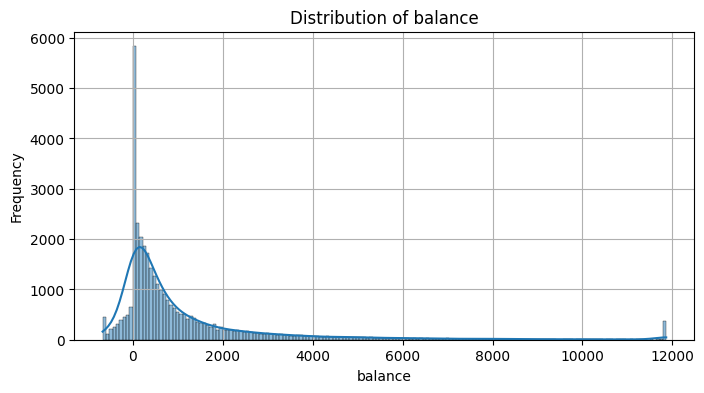

In [ ]:
X_no_outliers = X_train.copy()

# границы по квантилям 
b_lo, b_hi = X_no_outliers['balance'].quantile([0.01, 0.99]).values
c_lo, c_hi = 0, X_no_outliers['campaign'].quantile(0.99)
p_lo, p_hi = 0, X_no_outliers['previous'].quantile(0.99)

# если есть возраст — тоже аккуратно ограничим
if 'age' in X_no_outliers.columns:
    a_lo, a_hi = X_no_outliers['age'].quantile([0.01, 0.99]).values

# применяем winsorize_outliers из helper.py
X_no_outliers = winsorize_outliers(X_no_outliers, 'balance',
                                   lower_bound=b_lo, upper_bound=b_hi)
X_no_outliers = winsorize_outliers(X_no_outliers, 'campaign',
                                   lower_bound=c_lo, upper_bound=c_hi)
X_no_outliers = winsorize_outliers(X_no_outliers, 'previous',
                                   lower_bound=p_lo, upper_bound=p_hi)
if 'age' in X_no_outliers.columns:
    X_no_outliers = winsorize_outliers(X_no_outliers, 'age',
                                       lower_bound=a_lo, upper_bound=a_hi)

# посмотреть, как изменилась одна из фич
plot_hist_numeric(X_no_outliers, 'balance')

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 646
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 16
[LightGBM] [Info] [binar

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

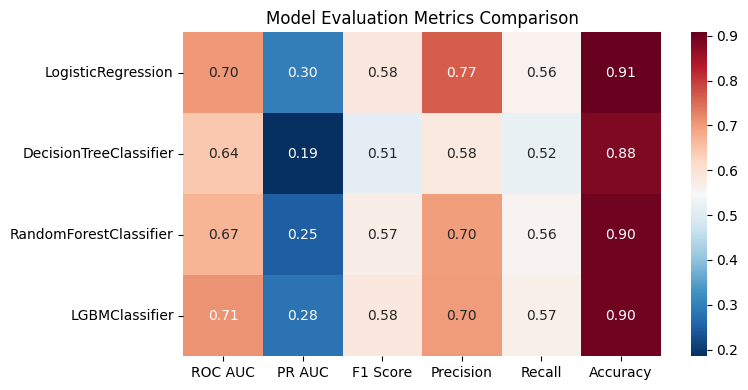

In [121]:
no_outliers_metrics = train_evaluate_models_cv(
    models=models,
    X=X_no_outliers,
    y=y_train,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.004078  0.003283 -0.002234   0.002043 -0.001923   
 DecisionTreeClassifier  0.000233  0.000310  0.000315   0.001867  0.000164   
 RandomForestClassifier -0.003671 -0.003355 -0.004219  -0.008477 -0.004013   
 LGBMClassifier         -0.001660 -0.002319 -0.002858  -0.021497 -0.000839   
 
                         Accuracy  
 LogisticRegression      0.000232  
 DecisionTreeClassifier  0.000033  
 RandomForestClassifier  0.000697  
 LGBMClassifier         -0.003451  )

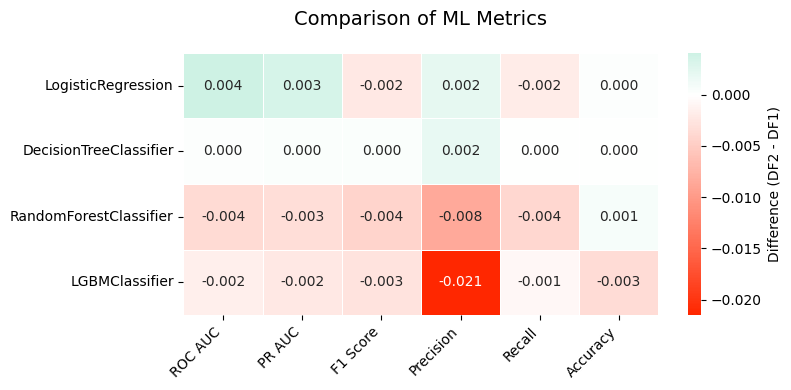

In [122]:
compare_metrics_heatmap(initial_metrics, no_outliers_metrics)

Ухудшения

### 2.9 Таргетное кодирование

In [123]:
categories_list = [cat_orders[col] for col in categorical_cols]

preprocessor_target_encoding = clone(preprocessor)
preprocessor_target_encoding['transformations'].transformers[0] = ('encoder', TargetEncoder(categories=categories_list), categorical_cols)

In [124]:
categorical_cols = [c for c in X_train.columns
                    if X_train[c].dtype.name in ('category', 'object')]

preprocessor_target_encoding = ColumnTransformer(
    transformers=[
        ('target_enc', TargetEncoder(categories='auto', smooth='auto'), categorical_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139599 -> initscore=-1.818628
[LightGB

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

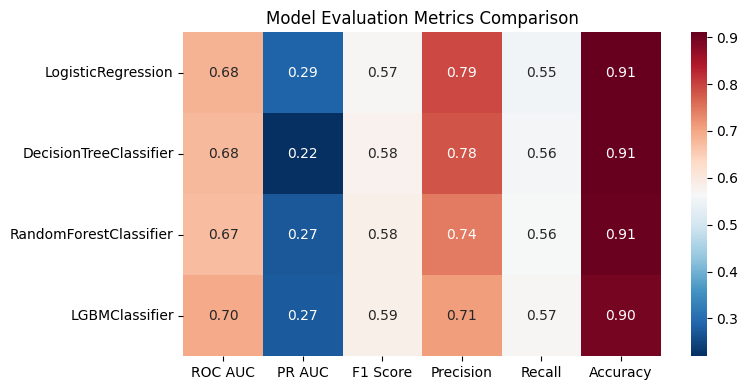

In [125]:
target_encoder_metrics = train_evaluate_models_cv(
    models=models,
    X=X_train,
    y=y_train,
    preprocessor=preprocessor_target_encoding,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression     -0.014425 -0.006770 -0.015990   0.029145 -0.012777   
 DecisionTreeClassifier  0.032704  0.034009  0.068900   0.201229  0.039449   
 RandomForestClassifier -0.003693  0.018762  0.008073   0.038262  0.002201   
 LGBMClassifier         -0.014213 -0.006233 -0.000894  -0.012254  0.000765   
 
                         Accuracy  
 LogisticRegression      0.002887  
 DecisionTreeClassifier  0.028401  
 RandomForestClassifier  0.007797  
 LGBMClassifier         -0.004612  )

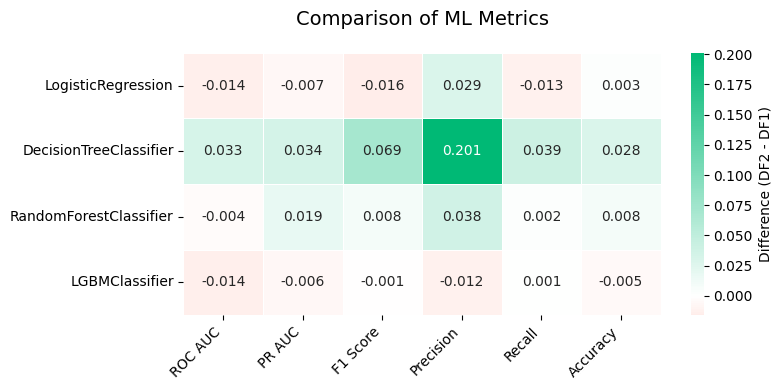

In [126]:
compare_metrics_heatmap(initial_metrics, target_encoder_metrics)

небольшие колебания

### 2.10 Работа с дисбалансом классов

#### 2.10.1 На уровне моделей

In [127]:
models_balanced = [
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear', class_weight='balanced')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4, class_weight='balanced')),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('LGBMClassifier', LGBMClassifier(random_state=SEED, class_weight='balanced'))
]

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

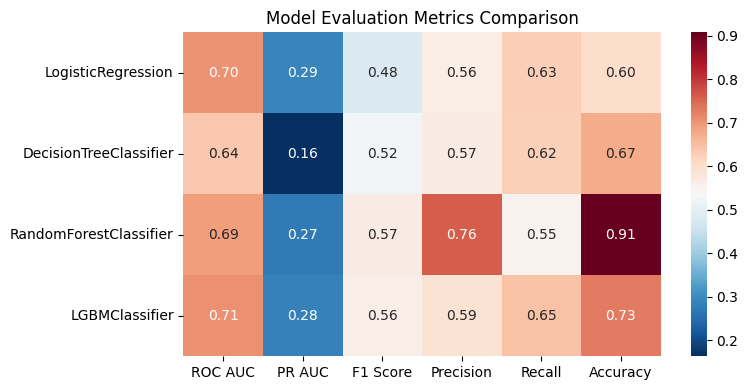

In [128]:
balanced_metrics = train_evaluate_models_cv(
    models=models_balanced,
    X=X_train,
    y=y_train,
    preprocessor=preprocessor,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.003119 -0.000895 -0.104109  -0.199401  0.062644   
 DecisionTreeClassifier -0.008287 -0.021357  0.010379  -0.013040  0.105520   
 RandomForestClassifier  0.015543  0.018718 -0.009095   0.054164 -0.009668   
 LGBMClassifier         -0.005736  0.002312 -0.026236  -0.133771  0.078103   
 
                         Accuracy  
 LogisticRegression     -0.304214  
 DecisionTreeClassifier -0.209489  
 RandomForestClassifier  0.009754  
 LGBMClassifier         -0.171334  )

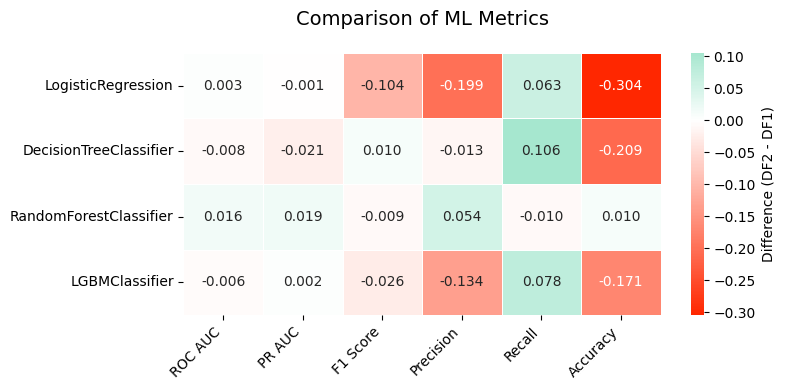

In [129]:
compare_metrics_heatmap(initial_metrics, balanced_metrics)

#### 2.10.2 Используя SMOTE

In [130]:
preprocessor_smote = clone(preprocessor)

preprocessor_smote.steps.append(
    ('smote', SMOTE(random_state=SEED))
)

c:\Users\theea\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[LightGBM] [Info] Number of positive: 4963, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 9926, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 10373, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 20746, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

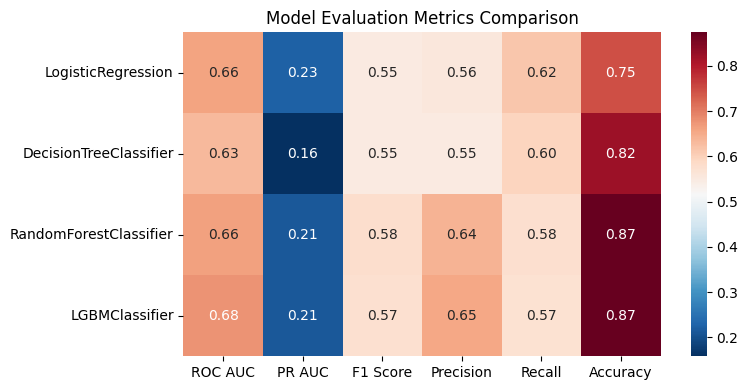

In [131]:
smote_metrics = train_evaluate_models_cv(
    models=models,
    X=X_train,
    y=y_train,
    preprocessor=preprocessor_smote,
    cv=cv,
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression     -0.039962 -0.067229 -0.036434  -0.207068  0.050473   
 DecisionTreeClassifier -0.010589 -0.026938  0.037350  -0.031672  0.077338   
 RandomForestClassifier -0.011714 -0.040789  0.004265  -0.064700  0.014316   
 LGBMClassifier         -0.033351 -0.067139 -0.011632  -0.068429  0.002885   
 
                         Accuracy  
 LogisticRegression     -0.159390  
 DecisionTreeClassifier -0.061082  
 RandomForestClassifier -0.025581  
 LGBMClassifier         -0.027306  )

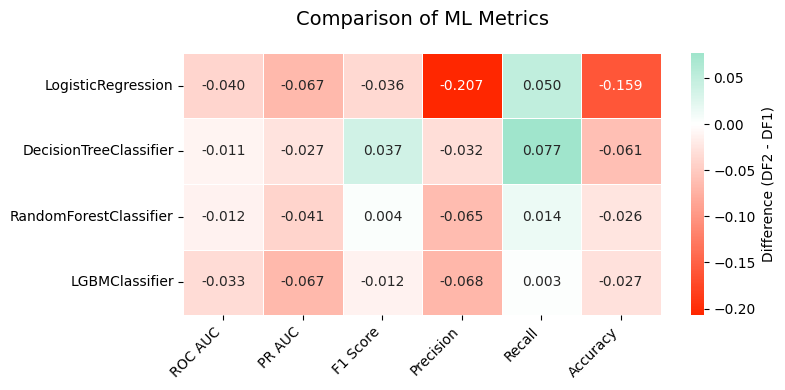

In [132]:
compare_metrics_heatmap(initial_metrics, smote_metrics)

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 16
[LightGBM] [Info] [binar

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

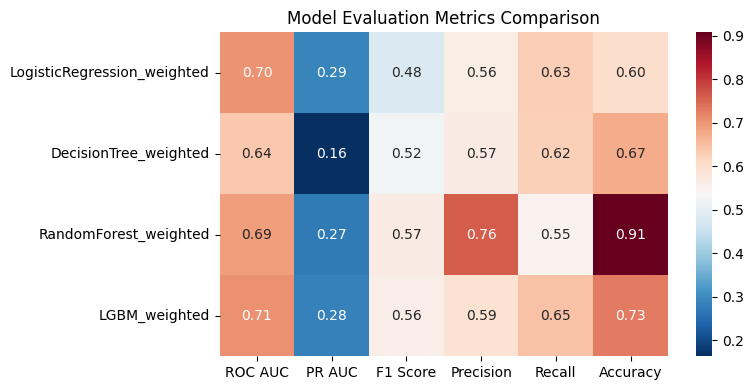

In [148]:
models_balanced = [
    ('LogisticRegression_weighted',
     LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', random_state=SEED)),
    ('DecisionTree_weighted',
     DecisionTreeClassifier(max_depth=4, class_weight='balanced', random_state=SEED)),
    ('RandomForest_weighted',
     RandomForestClassifier(class_weight='balanced', random_state=SEED)),
    ('LGBM_weighted',
     LGBMClassifier(class_weight='balanced', random_state=SEED))  # можно также is_unbalance=True
]

balanced_metrics = train_evaluate_models_cv(
    models=models_balanced,
    X=X_train, y=y_train,
    preprocessor=preprocessor,  # твой препроцессор
    cv=cv, seed=SEED
)

In [154]:
balanced_metrics_renamed = balanced_metrics.rename(index={
    'LogisticRegression_weighted': 'LogisticRegression',
    'DecisionTree_weighted' : 'DecisionTreeClassifier',
    'RandomForest_weighted': 'RandomForestClassifier',
    'LGBM_weighted': 'LGBMClassifier'
})

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.003119 -0.000895 -0.104109  -0.199401  0.062644   
 DecisionTreeClassifier -0.008287 -0.021357  0.010379  -0.013040  0.105520   
 RandomForestClassifier  0.015543  0.018718 -0.009095   0.054164 -0.009668   
 LGBMClassifier         -0.005736  0.002312 -0.026236  -0.133771  0.078103   
 
                         Accuracy  
 LogisticRegression     -0.304214  
 DecisionTreeClassifier -0.209489  
 RandomForestClassifier  0.009754  
 LGBMClassifier         -0.171334  )

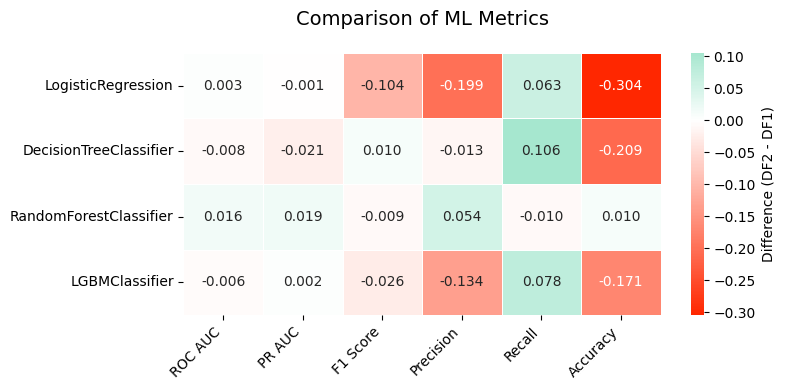

In [155]:
compare_metrics_heatmap(initial_metrics, balanced_metrics_renamed)

In [133]:
from imblearn.pipeline import Pipeline as ImbPipeline

[LightGBM] [Info] Number of positive: 4963, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 9926, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 10373, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 20746, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

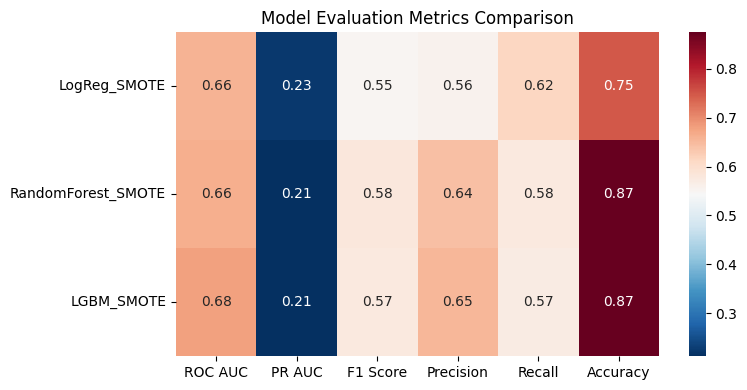

,ROC AUC,PR AUC,F1 Score,Precision,Recall,Accuracy
LogReg_SMOTE,0.658833,0.225009,0.549209,0.556819,0.615583,0.747843
RandomForest_SMOTE,0.662450,0.212472,0.579920,0.641626,0.575246,0.872230
LGBM_SMOTE,0.677870,0.213780,0.574503,0.653675,0.570149,0.874054


In [134]:
lr_smote = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=SEED, k_neighbors=5)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear', random_state=SEED))
])

rf_smote = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=SEED)),
    ('clf', RandomForestClassifier(random_state=SEED))
])

lgbm_smote = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=SEED)),
    ('clf', LGBMClassifier(random_state=SEED))
])

models_smote = [
    ('LogReg_SMOTE', lr_smote),
    ('RandomForest_SMOTE', rf_smote),
    ('LGBM_SMOTE', lgbm_smote),
]

smote_metrics = train_evaluate_models_cv(
    models=models_smote,
    X=X_train, y=y_train,
    preprocessor=preprocessor,
    cv=cv, seed=SEED
)
smote_metrics

In [135]:
smote_metrics_renamed = smote_metrics.rename(index={
    'LogReg_SMOTE': 'LogisticRegression',
    'RandomForest_SMOTE': 'RandomForestClassifier',
    'LGBM_SMOTE': 'LGBMClassifier'
})

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 DecisionTreeClassifier       NaN       NaN       NaN        NaN       NaN   
 LGBMClassifier         -0.033351 -0.067139 -0.011632  -0.068429  0.002885   
 LogisticRegression     -0.039962 -0.067229 -0.036434  -0.207068  0.050473   
 RandomForestClassifier -0.011714 -0.040789  0.004265  -0.064700  0.014316   
 
                         Accuracy  
 DecisionTreeClassifier       NaN  
 LGBMClassifier         -0.027306  
 LogisticRegression     -0.159390  
 RandomForestClassifier -0.025581  )

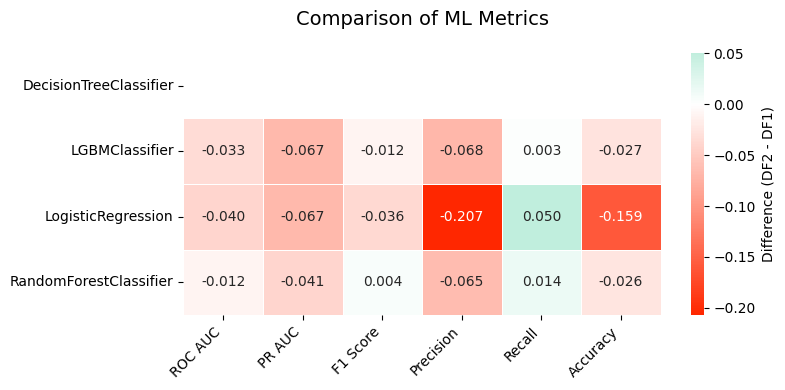

In [136]:
compare_metrics_heatmap(initial_metrics, smote_metrics_renamed)

### 2.11 Итоговый результат

Из всех преобразований только биннинг дал хоть какие-то улучшения, его мы и применим к данным

In [156]:
X_final = X_train.copy()

In [157]:
bins   = [-np.inf, 1, 3, 5, np.inf]
labels = [0, 1, 2, 3]

X_final['campaign_bins'] = pd.cut(
    X_final['campaign'], bins=bins, labels=labels
).astype('int16')

In [158]:
preprocessor_final = clone(preprocessor)
preprocessor_final['nan_remover'].transformers[0][2].append('campaign_bins')

[LightGBM] [Info] Number of positive: 1065, number of negative: 4963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 6028, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.176676 -> initscore=-1.539036
[LightGBM] [Info] Start training from score -1.539036
[LightGBM] [Info] Number of positive: 1683, number of negative: 10373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 12056, number of used features: 17
[LightGBM] [Info] [binar

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

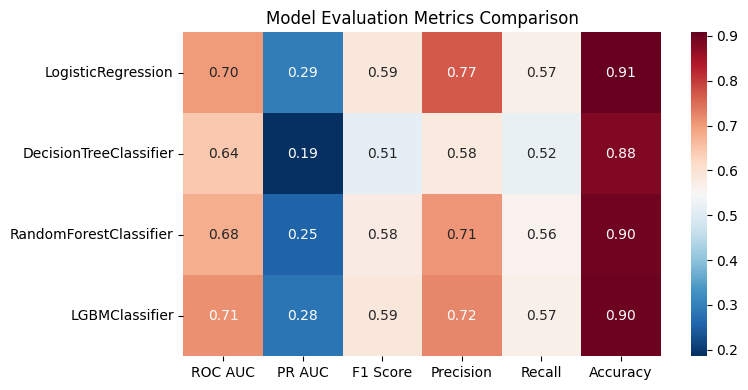

In [159]:
final_metrics = train_evaluate_models_cv(
    models=models,
    X=X_final,
    y=y_train,
    preprocessor=preprocessor_final,
    cv=cv,   
    seed=SEED
)

(<Figure size 800x400 with 2 Axes>,
                          ROC AUC    PR AUC  F1 Score  Precision    Recall  \
 LogisticRegression      0.001798  0.001714  0.003145   0.004808  0.002153   
 DecisionTreeClassifier  0.000036  0.000202  0.000009   0.000001  0.000018   
 RandomForestClassifier  0.003185 -0.000066  0.001676  -0.001165  0.001030   
 LGBMClassifier          0.000846  0.000395  0.000603   0.001585  0.000452   
 
                         Accuracy  
 LogisticRegression      0.000796  
 DecisionTreeClassifier  0.000033  
 RandomForestClassifier -0.000431  
 LGBMClassifier          0.000299  )

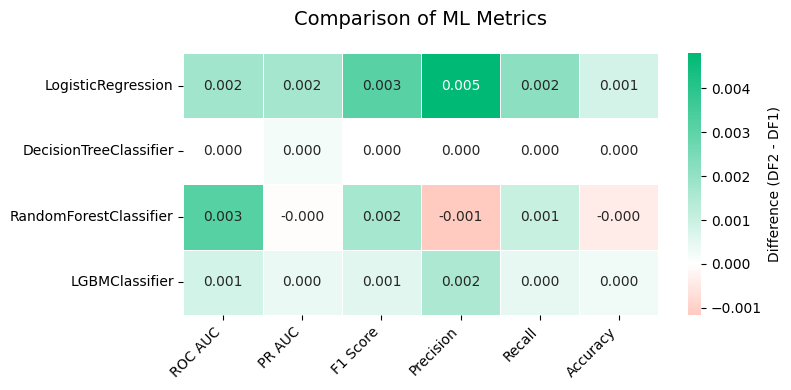

In [160]:
compare_metrics_heatmap(initial_metrics, final_metrics)